Run suite2p in colab
*   Accessing data directly from Google Drive Remote Repos
*   Saves data to processed Remote Repos
*   Has option to make suite2p output files smaller for easier local suite2p GUI use




## Setup

In [2]:
import os #, requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import suite2p
import timeit

/home/adamranson/miniconda3/envs/suite2p/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': True,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

/tmp/ipykernel_339707/1874460755.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap('jet')


In [4]:
ops = suite2p.default_ops()
ops['batch_size'] = 40 # we will decrease the batch_size in case low RAM on computer
ops['threshold_scaling'] = 2.0 # we are increasing the threshold for finding ROIs to limit the number of non-cell ROIs found (sometimes useful in gcamp injections)
ops['fs'] = 13 # sampling rate of recording, determines binning for cell detection
ops['tau'] = 1.25 # timescale of gcamp to use for deconvolution
ops['move_bin'] = True
ops['save_mat'] = True

## Options

In [5]:
# expID
expID = '2023-02-28_11_ESMT116'
# user ID to use to place processed data
userID = 'adamranson'
# should smaller version of suite2p output be produced?
shrink_s2p = True


## Set pipeline parameters

You can find an explanation of each op parameters [here](https://suite2p.readthedocs.io/en/latest/settings.html).

## Set Data Path
`ops` and `db` are functionally equivalent internally in suite2p, with the exception that parameters provided in `db` will overwrite parameters specified in `ops`.

**Tip**:  Since it's common to change datasets and keep the same parameters for each dataset, some might find it useful to specify data-related arguments in `db` and pipeline parameters in `ops`. 

In [6]:
# get animal ID from experiment ID
animalID = expID[14:]
# path to root of raw data
remote_repository_root = '/home/adamranson/data/Remote'
# path to root of processed data
processed_root = '/home/adamranson/data/Repository'
# complete path to raw experiment data
exp_dir = os.path.join(remote_repository_root,animalID,expID)
# complete path to processed experiment data
exp_dir_processed = os.path.join(processed_root,animalID,expID)

db = {
  'data_path': [exp_dir],
  'save_path0': exp_dir_processed,
  'save_disk': exp_dir_processed,
  #'fast_disk': '/data/fast', # <-- this is the VM's disk space
}

print(db)
print(ops)

{'data_path': ['/home/adamranson/data/Remote/ESMT116/2023-02-28_11_ESMT116'], 'save_path0': '/home/adamranson/data/Repository/ESMT116/2023-02-28_11_ESMT116', 'save_disk': '/home/adamranson/data/Repository/ESMT116/2023-02-28_11_ESMT116'}
{'suite2p_version': '0.12.0', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': True, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.25, 'fs': 13, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': True, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': True, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 4

## Run Suite2p on Data

The `suite2p.run_s2p` function runs the pipeline and returns a list of output dictionaries containing the pipeline parameters used and extra data calculated along the way, one for each plane.

In [7]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['/home/adamranson/data/Remote/ESMT116/2023-02-28_11_ESMT116'], 'save_path0': '/home/adamranson/data/Repository/ESMT116/2023-02-28_11_ESMT116', 'save_disk': '/home/adamranson/data/Repository/ESMT116/2023-02-28_11_ESMT116'}
FOUND BINARIES AND OPS IN ['/home/adamranson/data/Repository/ESMT116/2023-02-28_11_ESMT116/suite2p/plane0/ops.npy']
removing previous detection and extraction files, if present
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying default /home/adamranson/.suite2p/classifiers/classifier_user.npy
----------- REGISTRATION
Reference frame, 20.21 sec.
Registered 40/62442 in 1.64s
Registered 80/62442 in 2.69s
Registered 120/62442 in 3.95s
Registered 160/62442 in 5.02s
Registered 200/62442 in 6.07s
Registered 240/62442 in 7.11s
Registered 280/62442 in 8.18s
Registered 320/62442 in 9.38s
Registered 360/62442 in 10.40s
Registered 400/6244

: 

: 

## Shrink suite2p output files

If you are running a very large experiment it will be almost impossible to stream it from GDrive on your local computer when you come to curate it in Suite2P GUI. This section produces a smaller version of F, Fneu and spks files (which are the big ones) by only including the first 500 frames (i.e. about 17 seconds at 30fps).

In [ ]:
# determine number of planes
s2p_output_dir = os.path.join(exp_dir_processed,'suite2p')
print(s2p_output_dir)
filenames= os.listdir(s2p_output_dir)
# iterate through each depth
for iPlane in range(0, len(filenames)):
    plane_dir = os.path.join(s2p_output_dir,'plane'+ str(iPlane))
    print("We're on " + 'plane'+ str(iPlane))
    print(plane_dir)
    starttime = timeit.default_timer()
    print('Starting download...')
    F = np.load(os.path.join(plane_dir,'F.npy'))
    Fneu = np.load(os.path.join(plane_dir,'Fneu.npy'))
    spks = np.load(os.path.join(plane_dir,'spks.npy'))
    print("Download time is :", timeit.default_timer() - starttime)
    # rename the original files
    os.rename(os.path.join(plane_dir,'F.npy'),os.path.join(plane_dir,'F_big.npy'))
    os.rename(os.path.join(plane_dir,'Fneu.npy'),os.path.join(plane_dir,'Fneu_big.npy'))
    os.rename(os.path.join(plane_dir,'spks.npy'),os.path.join(plane_dir,'spks_big.npy'))
    # truncate the original files to < 500 frames
    n_frames = F.shape
    print(n_frames[0:])
    # check if they are already < 500 frames
    if n_frames[1] > 500:
      print('More than 500')
      F = F[0:,0:500]
      Fneu = F[0:,0:500]
      spks = F[0:,0:500]
    else:
      print('Less than 500')
    # save the truncated versions
    np.save(os.path.join(plane_dir,'F.npy'),F)
    np.save(os.path.join(plane_dir,'Fneu.npy'),Fneu)
    np.save(os.path.join(plane_dir,'spks.npy'),spks)

/home/adamranson/data/Repository/adamranson/ESMT116/2023-02-28_11_ESMT116/suite2p
We're on plane0
/home/adamranson/data/Repository/adamranson/ESMT116/2023-02-28_11_ESMT116/suite2p/plane0
Starting download...
Download time is : 0.000772748957388103
(10, 920)
More than 500


### Outputs from the Suite2p Pipeline

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [ ]:
output_ops_file = np.load(Path(output_ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_ops_file.keys() == output_ops.keys()

True

The other files will be used for the visualizations in the section below.


## Visualizations

### Registration

Registration computes a reference image from a subset of frames and registers all frames to the reference. 

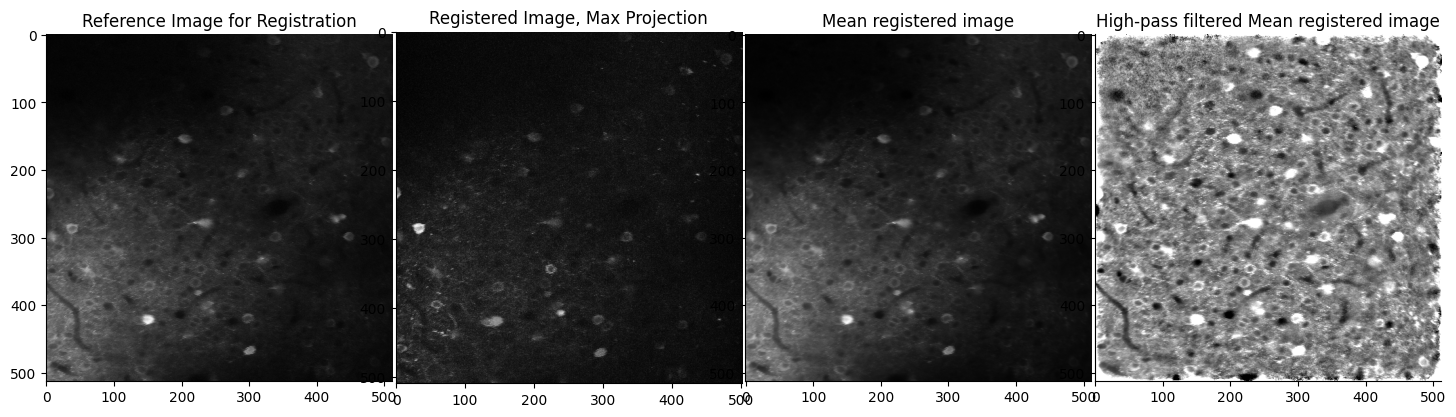

In [ ]:
plt.subplot(1, 4, 1)

plt.imshow(output_ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

# maximum of recording over time
plt.subplot(1, 4, 2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

The rigid offsets of the frame from the reference are saved in `output_ops['yoff']` and `output_ops['xoff']`. The nonrigid offsets are saved in `output_ops['yoff1']` and `output_ops['xoff1']`, and each column is the offsets for a block (128 x 128 pixels by default).

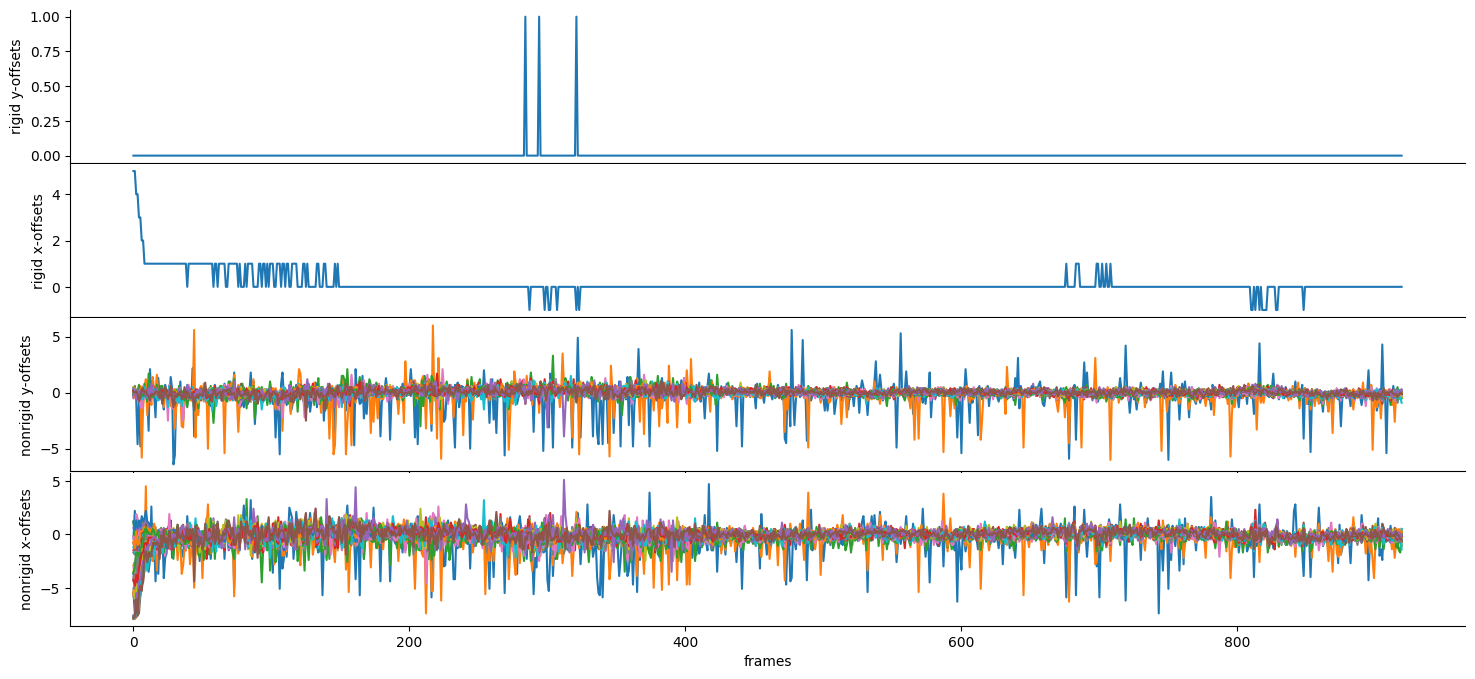

In [ ]:
plt.figure(figsize=(18,8))

plt.subplot(4,1,1)
plt.plot(output_ops['yoff'][:1000])
plt.ylabel('rigid y-offsets')

plt.subplot(4,1,2)
plt.plot(output_ops['xoff'][:1000])
plt.ylabel('rigid x-offsets')

plt.subplot(4,1,3)
plt.plot(output_ops['yoff1'][:1000])
plt.ylabel('nonrigid y-offsets')

plt.subplot(4,1,4)
plt.plot(output_ops['xoff1'][:1000])
plt.ylabel('nonrigid x-offsets')
plt.xlabel('frames')

plt.show()


In [ ]:
#@title Run cell to look at registered frames
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from suite2p.io import BinaryFile

widget = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


def plot_frame(t):
    with BinaryFile(Ly=output_ops['Ly'],
                Lx=output_ops['Lx'],
                read_filename=output_ops['reg_file']) as f:
        plt.imshow(f[t][0])

interact(plot_frame, t=(0, output_ops['nframes'], 1));

ModuleNotFoundError: No module named 'ipywidgets'

Here in the notebook is not the best/fastest way to play the movie, you can play it in the suite2p GUI in the "View registered binary" player.

### Detection

ROIs are found by searching for sparse signals that are correlated spatially in the FOV. The ROIs are saved in `stat.npy` as a list of dictionaries which contain the pixels of the ROI and their weights (`stat['ypix']`, `stat['xpix']`, and `stat['lam']`). It also contains other spatial properties of the ROIs such as their aspect ratio and compactness, and properties of the signal such as the skewness of the fluorescence signal.


In [ ]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(int)
stats = np.load(stats_file, allow_pickle=True)
print(stats[0].keys())

Some ROIs are defined as "cells" (somatic ROIs) or "not cells" (all other ROIs) depending on their properties, like skewness, compactness, etc. Below we will visualize the ROIs, but please open the files in the suite2p GUI for closer inspection.

In [ ]:
Ly, Lx = output_ops["meanImg"].shape


In [ ]:
n_cells = len(stats)

h = np.random.rand(n_cells)
hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)

for i, stat in enumerate(stats):
    ypix, xpix, lam = stat['ypix'], stat['xpix'], stat['lam']
    hsvs[iscell[i], ypix, xpix, 0] = h[i]
    hsvs[iscell[i], ypix, xpix, 1] = 1
    hsvs[iscell[i], ypix, xpix, 2] = lam / lam.max()

from colorsys import hsv_to_rgb
rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)

plt.figure(figsize=(18,18))
plt.subplot(3, 1, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(3, 1, 2)
plt.imshow(rgbs[1])
plt.title("All Cell ROIs")

plt.subplot(3, 1, 3)
plt.imshow(rgbs[0])
plt.title("All non-Cell ROIs");

plt.tight_layout()